 # Grokking on division mod 97

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
from torch import Tensor
from torch.nn.functional import cross_entropy
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from net import Grokformer
from data_factory import create_algorithmic, divide

### Helper function
Define a function to evaluate the model on some data.

In [2]:
def get_acc(model: Grokformer, data: Tensor, labels: Tensor):
    model.train(False)
    with torch.no_grad():
        scores = model(data)
        res = torch.argmax(scores, dim=1, keepdim=False)
    match = torch.where(res == labels, True, False)
    return torch.count_nonzero(match).cpu().item() / match.shape[0]

### Training
Training the network on mod 97 division on 30% of the data.

Parameters

In [4]:
steps = 20000
train_ratio = 0.3
table_size = 97
device = torch.device("cuda:0")

Creating the data.

In [5]:
data = create_algorithmic(table_size, divide(table_size), device)
# Filter instances where <y> = 0, we don't need those as they are invalid.
idx = torch.where(data[:, 2] == 0, False, True)
data = data[idx]

In [ ]:
# These record accuracy values throughout training, wil be used when plotting.
accs_tr = []
accs_val = []

# Create random train and validation sets.
data_index = torch.randperm(data.shape[0], device=device)
split = int(data.shape[0] * train_ratio)
training_set = data[data_index[:split]]
validation_set = data[data_index[split:]]

# Creating the model.
net = Grokformer(num_embeddings=99, embedding_dim=128, device=device)
optimizer = AdamW(net.parameters(), lr=1e-3, weight_decay=1., betas=(0.9, 0.98))
scheduler = LambdaLR(optimizer, lambda e: min(e/10, 1.))

# Training and evaluating after each epoch.
c = 0
while True:
    data = training_set
    # Creating input data and labels.
    for start in range(0, data.shape[0], 512):
        net.train(True)
        d = data[start:start + 512]  # d: (batch_size, 5)
        x = d[:, :-1]  # x: (batch_size, 4)
        y = d[:, -1].flatten()  # y: (batch_size,)

        optimizer.zero_grad()

        scores = net(x)
        loss = cross_entropy(input=scores, target=y.to(torch.long))

        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

        print(f"Optim step {c}")
        acc_train = get_acc(net, training_set[:, :-1], training_set[:, -1].flatten().to(torch.long))
        accs_tr.append(acc_train)
        print(f"Training accuracy:\t{acc_train*100:.3f}%")

        acc_val = get_acc(net, validation_set[:, :-1], validation_set[:, -1].flatten().to(torch.long))
        accs_val.append(acc_val)
        print(f"Validation accuracy:\t{acc_val * 100:.3f}%\n")
        c += 1
        if c >= steps:
            break
    if c >= steps:
        break

### Plot the results
Only plot every $\mathcal{skip}$ points, otherwise the plot gets too cluttered and it becomes really hard to see anything.

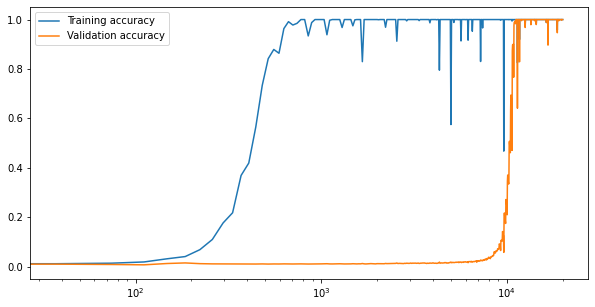

In [53]:
skip = 37
plt.figure(figsize=(10,5))
plt.xscale("log")
s = slice(None, None, skip)
nums = list(range((len(accs_val))))
plt.plot(nums[s], accs_tr[s], label="Training accuracy")
plt.plot(nums[s], accs_val[s], label="Validation accuracy")
plt.legend(loc="upper left")
plt.show()